In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 3.5)
figsize_narrow=(14, 2.5)

use_cached_weights=True

from util import util
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# From PFL to DFL

Eyes on the prize

## Prediction and Optimization in the Wild

**Real world problems typically rely on _estimated parameters_**

E.g. travel times, demands, item weights/costs...

<center><img src="assets/traffic.jpg" width="70%"/></center>

**However, sometimes we have access to _a bit more information_**

## Prediction and Optimization in the Wild

**Take _traffic-dependent travel times_ as an example**

If we know the _time of the day_ we can probably estimate them better

<center><img src="assets/traffic.jpg" width="70%"/></center>

**Let's see how these problems are often addressed**

## Predict...

**First, we train _an estimator for the problem parameters_:**

$$
\theta^* = \text{argmin}_{\theta} \{\mathbb{E}_{(x, y) \sim P(X, Y)}[L(y, \hat{y})] \mid \hat{y} = h(x, \theta)\}
$$

* $L$ is the single-example loss (typically a likelihood)
* $h$ is the estimator, with parameter vector $\theta$
* $P(X, Y)$ is the data distribution
* ...Which will typically be approximated via a sample (training set)

**In our example:**

* $x$ would be the time of the day
* $y$ would be a vector of travel times

## ...Then Optimize

**Then, we _solve the optimization problem_ with the estimated parameters**

$$
z^*(y) = \text{argmin}_z \left\{ f(z, y) \mid z \in F \right\}
$$
* $z$ is the vector of variables of the optimization problem
* $f$ is the cost function
* $F$ is the feasible space
* In general, both $y$ and $F$ may depend on the estimated parameters

**In our example**

* $z$ may represent routing decisions
* $f$ may be the total travel time
* $F$ may encode a deadline constraint

## Inference

**This setup involves using the estimator and the optimizer in sequence**


<center><br><img src="assets/dfl_setup.png" width=70%></center>

At inference time:

* We observe $x$
* We evaluate our estimator $h(x; \theta)$ to obtain $\hat{y}$
* We solve the problem to obtain $z^*(\hat{y})$

**Overall, the process consists in evaluating:**

$$
z^*(h(x; \theta))
$$

## Prediction Focused Learning

**This two-stage approach used to have no name at all**

These days, it is referred to as:

* Predict, then Optimize
* ...Or _Prediction Focused Learning_

**PFL has several favorable properties:**

* It's _easy to implement_
* ...It has _good scalability_
* ...And it's asymptotically correct (perfect predictions result in minimum cost)

Application fields include logistics, planning, finance, etc.

<div class=big>
However, the method has also a significant flaw<br>
<small>One that was only <a href="https://proceedings.neurips.cc/paper/2017/file/3fc2c60b5782f641f76bcefc39fb2392-Paper.pdf">recently emphasized</a></small>
</div>

## A Toy Problem

**Let's see this in action on a toy problem** 

Consider this two-variable optimization problem:

$$
\text{argmin}_{z} \{y_0 z_0 + y_1 z_1 \mid z_0 + z_1 = 1, z \in \{0, 1\}^2\}
$$

Let's assume that the true relation between $x$ (a scalar) and $y$ is:

$$\begin{align}
y_0 &= 2.5 x^2 \\
y_1 &= 0.3 + 0.8 x
\end{align}$$

...But that we can only learn the following ML model with a scalar weight $\theta$:

$$\begin{align}
\hat{y}_0 &= \theta^2 x \\
\hat{y}_1 &= 0.5 \theta
\end{align}$$

**Our model cannot represent the true relation exactly**

## Spotting Trouble

**This is what we get from supervised learning with uniformly distributed data:**

Optimized theta: 1.375


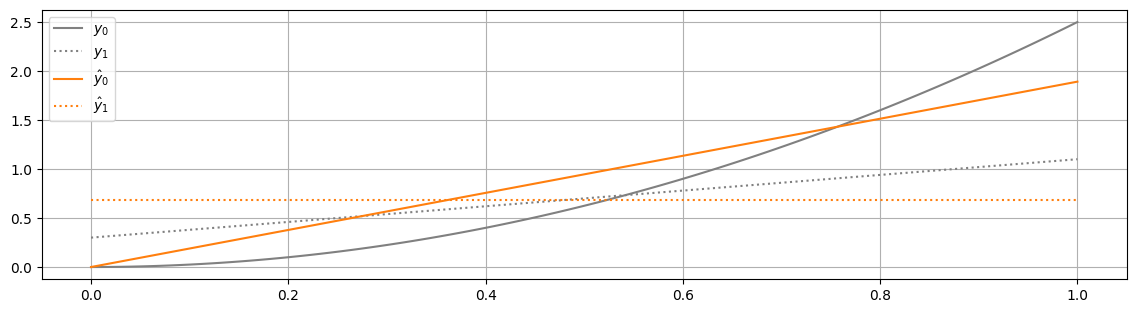

In [2]:
util.draw(w=None, figsize=figsize, model=1)

* The crossing point of the grey lines is where we should pick item 0 instead of 1
* The orange lines (trained model) miss it _by a wide margin_

<div class=big>
Hence, if we optimize based on our best predictions, we make mistakes!<br>
    <small>...But why is this happening?</small>
</div>

## Misaligned Objectives

**We trained for _maximum accuracy_ regardless of the decision cost!**

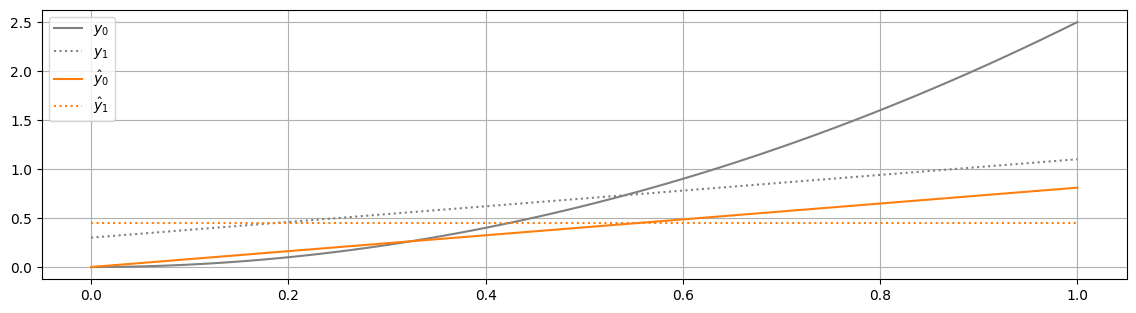

In [5]:
util.draw(w=0.9, figsize=figsize, model=1)

* However, if we focus on choosing $\theta$ to _match the crossing point_
* ...The same model can lead the optimizer consistently to the correct choice

<div class=big>
    We just need to train for <em>minimanl decision cost</em>,
    which is key idea in <em>Decision Focused Learning</em>
</div>

## Getting Started

**We'll start withe setup considered in [one of the DFL seminal papers](https://pubsonline.informs.org/doi/pdf/10.1287/mnsc.2020.3922?casa_token=xvCLCIEUkp8AAAAA:TKyWe3aFxZVJ0BqAIH6LT_vLMGJ8BSdAqxpzyGnRBXF6oZzYTjj_U6Ip8zq7_WVFizthJsR40g)**

We consider an optimization problem in the form:

$$
z^*(y) = \text{argmin}_{z} \{y^T z \mid z \in F\}
$$

* $z$ is the set of _decisions_
* $F$ is the _feasible space_
* $y$ is a cost vector

**The $y$ parameters _cannot be measured_**

...But they depend on _some observable $x$_

* And both can be represented as random variables with a joint distribution:

$$
X, Y \sim P(X, Y)
$$

## Getting Started

**So, in practice we can estimate $y$ via a ML model**

$$
\hat{y} = h(x; \theta)
$$

...And at inference time we get our decisions by computing:

$$
z^*(h(x; \theta))
$$

I.e. exactly as in Prediction Focused Learning

**The key assumption is the use of a _linear cost function_**

...And the _lack of dependence of the constraints on $y$_

* The constraint can otherwise be anything (including integrality)
* ...And they could also depend on the observable, i.e. $F \equiv F(x)$

## The Main DFL Idea

**The key difference between PFL and DFL is _the training process_**

...Whic in DFL is done by minimizing a _decision cost_, i.e. by solving:

$$
\theta^* = \text{argmin}_\theta \{\mathbb{E}_{(x, y) \sim P(X, Y)}[\text{regret}(y, \hat{y})] \mid \hat{y} = h(x, \theta)\}
$$

Where in our setting we have:

$$
\text{regret}(y, \hat{y}) = y^T z^*(\hat{y}) - y^T z^*(y)
$$

* $z^*(\hat{y})$ is the best solution with the _estimated_ costs
* $z^*(y)$ is the best solution with the _true_ costs

Intuitively, we want to _loose as little as possible_ w.r.t. the best we could do

<div class=big>
One of the main challenges in DFL is dealing with this loss
</div>

## Knowing Regret

**To see this, let's push our example a little further**

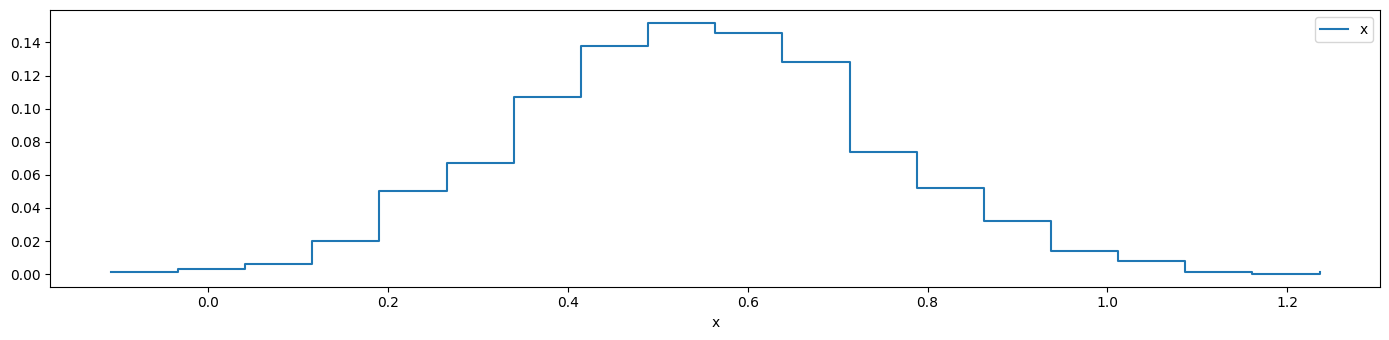

In [6]:
x = util.normal_sample_(mean=0.54, std=0.2, size=1000)
util.plot_histogram(x, figsize=figsize, label='x')

* Say we have access to a normally distributed collection of $x$ values
* ...And to the corresponding true values $y$

## Knowing Regret

**This is how the regret looks like for a single example**

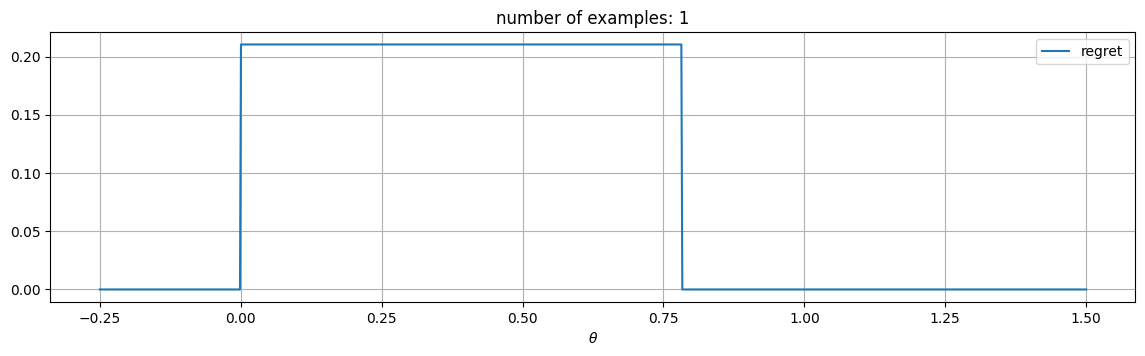

In [7]:
util.draw_loss_landscape(losses=[util.RegretLoss()], model=1, seed=42, batch_size=1, figsize=figsize)

* If $f(x, \theta)$ leads to the correct decision, the regret is 0
* Otherwise we have some non-null value

## Knowing Regret

**...And this is the same for a larger sample**

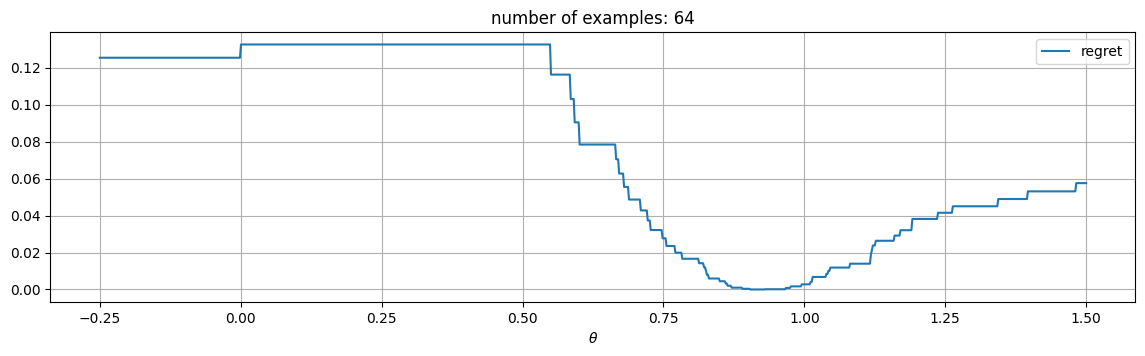

In [9]:
util.draw_loss_landscape(losses=[util.RegretLoss()], model=1, seed=42, batch_size=64, figsize=figsize)

This function breaks havoc with gradient descent, for _two main reasons_

## What's Wrong with Regret (1)

**As a first issue, the loss is _not inherently differentiable_**

Given:

$$
\text{regret}(y, \hat{y}) = y^T z^*(\hat{y}) - y^T z^*(y) \quad \text{ with: } \hat{y} = h(x; \theta)
$$

The derivative chain:

$$
\frac{\partial\, \text{regret}}{\partial \theta} =
\frac{\partial\, \text{regret}}{\partial z^*}
\color{red}{\frac{\partial\, z^*}{\partial \hat{y}}}
\frac{\partial\, \hat{y}}{\partial \theta}
$$

...Contains a term that is based on an $\text{argmin}$ operator

* For this reason, computing the derivative might be tricky
* ...And for some $\hat{y}$ values a derivative might not be defined at all

## What's Wrong with Regret (2)

**Second, when the derivative exists, it might be _useless_**

E.g. for combinatorial and linear problems, regret will be _piecewise constant_

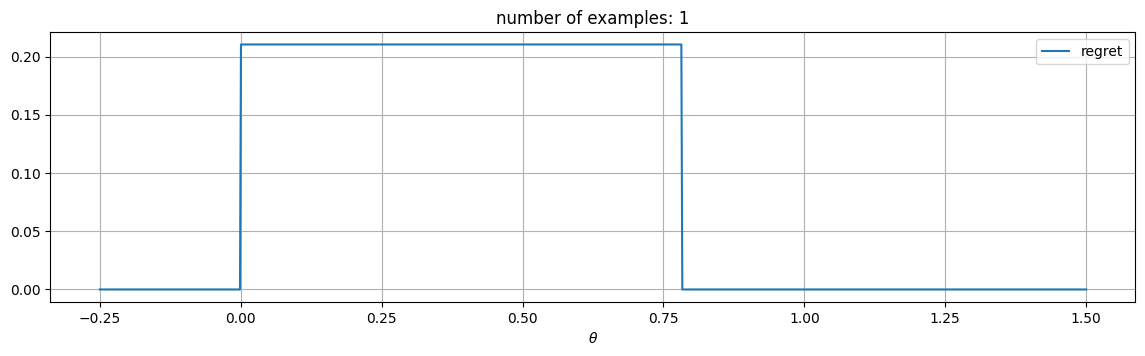

In [10]:
util.draw_loss_landscape(losses=[util.RegretLoss()], model=1, seed=42, batch_size=1, figsize=figsize)

When the derivative is defined, _its value is 0_

## Self-Contrastive Loss

**These issues have been addressed [in multiple ways](https://arxiv.org/pdf/2307.13565)**

Here we'll start with the idea of _changing perspective_

* In particular, any prediction vector $\hat{y}$ defines a cost function:

$$
\hat{y}^T z
$$

* ...Which will lead the solver toward the optimal solution:

$$
z^*(\hat{y})
$$

**Given an example $(x, y)$, for a _good_ prediction vector $\hat{y}$**

* The cost of the _true_ optimal solution $z^*(y)$
* ...Should not be worse than the cost of the _"estimated"_ optimal solution $z^*(\hat{y})$

## Self-Contrastive Loss

**Hence we can think of using as a _surrogate loss_ the difference:**

$$
\hat{y}^T z^*(y) - \hat{y}^T z^*(\hat{y})
$$

It represents "how wrong" the estimated cost function is w.r.t. the true one

* It contains a naturally differentiable term (i.e. $\hat{y}$)
* It is not constant, even when $z^*$ is piecewise constant

**A sub-gradient represents the difference between the optimal solutions:**

$$
\nabla \left( \hat{y}^T z^*(y) - \hat{y}^T z^*(\hat{y}) \right) = z^*(y) - z^*(\hat{y})
$$

In the DFL literature, this is known as _self-contrastive loss_

## Limitations of the Self-Contrastive Loss

**However, the self-constrastive loss has some significant limitations**

Here's how it looks for one example in our toy problem:

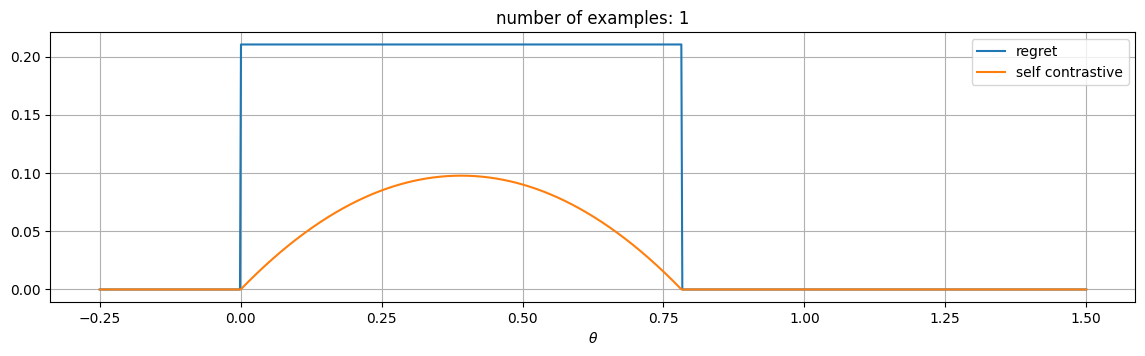

In [11]:
util.draw_loss_landscape(losses=[util.RegretLoss(), util.SelfContrastiveLoss()], model=1, seed=42, batch_size=1, figsize=figsize)

## Limitations of the Self-Contrastive Loss

**Here's the plot for multiple examples**

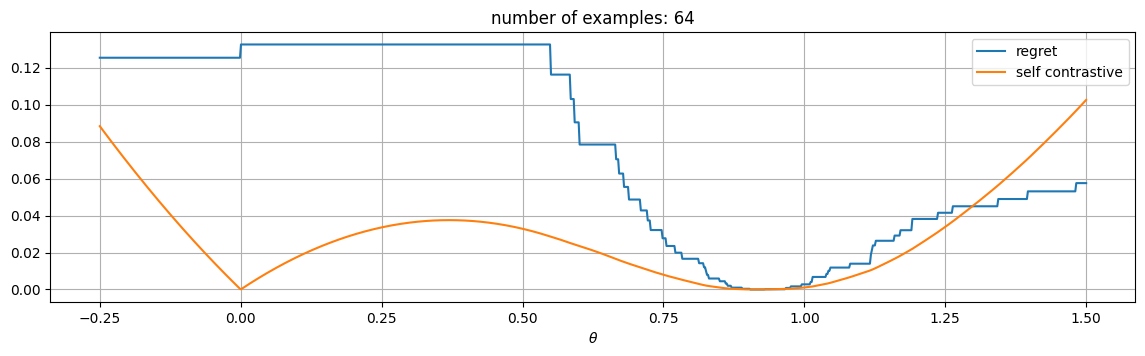

In [12]:
util.draw_loss_landscape(losses=[util.RegretLoss(), util.SelfContrastiveLoss()], model=1, seed=42, batch_size=64, figsize=figsize)

There's a problem here! **Can you see which one?**

## Limitations of the Self-Contrastive Loss

**There's _a spurious minimum_!**

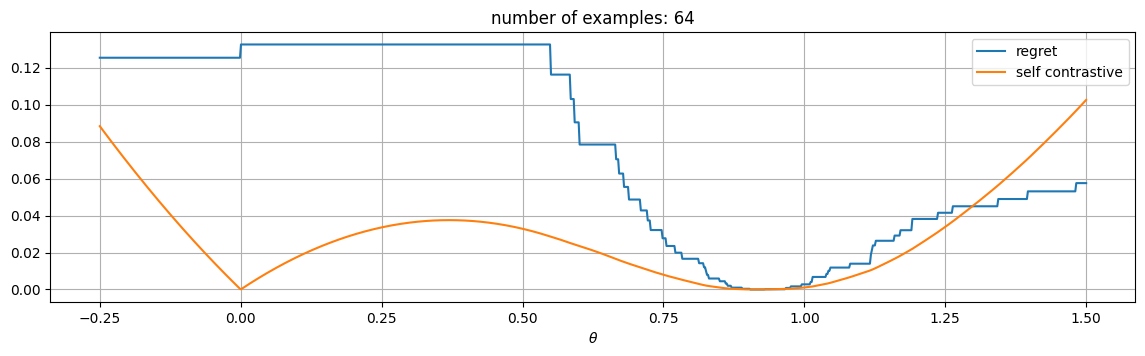

In [13]:
util.draw_loss_landscape(losses=[util.RegretLoss(), util.SelfContrastiveLoss()], model=1, seed=42, batch_size=64, figsize=figsize)

At training time, there's a chance of reaching _the wrong minimum_!

## SPO+ Loss

**A well-known DFL approach can be seen as solution for this issue**

I.e. the SPO+ loss from [1], which can be defined as:

$$
\text{spo}^+(y, \hat{y}) = \hat{y}_{spo}^T z^*(y) - \hat{y}_{spo}^T z^*(\hat{y}_{spo})
\quad
\text{ with: }
\quad
\hat{y}_{spo} = 2 \hat{y} - y
$$

* The structure is the same as the self-constrastive loss
* ...But _at training time_ we compute it w.r.t. a modified prediction vector

**At inference time we behave as usual, i.e. we solve:**

$$
z^*(\hat{y}) \quad \text{ with: } \hat{y} = h(x; \theta)
$$

<small><i>
[1] Elmachtoub, Adam N., and Paul Grigas. "Smart “predict, then optimize”." Management Science 68.1 (2022): 9-26.
</i></small>

## SPO+ Loss

**This is the SPO+ loss for a single example on our toy problem**

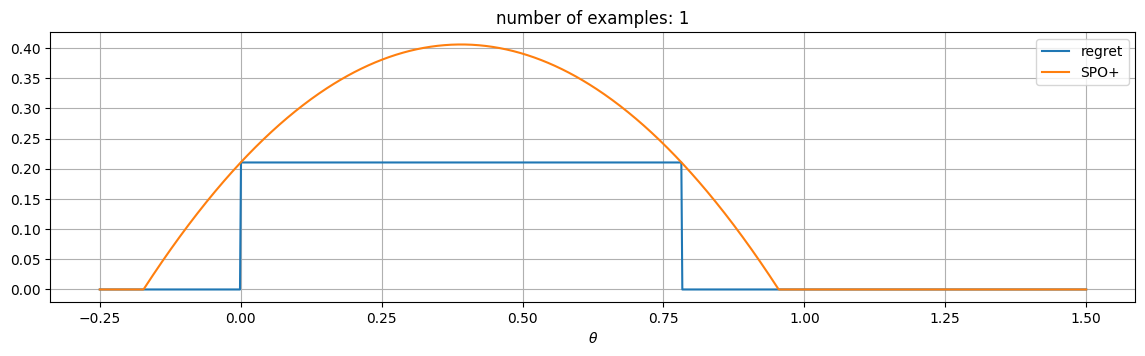

In [14]:
util.draw_loss_landscape(losses=[util.RegretLoss(), util.SPOPlusLoss()], model=1, seed=42, batch_size=1, figsize=figsize)

* Like in the self-constrastive case, there are two local minima

## SPO+ Loss

**This is the SPO+ loss for a _two examples_**

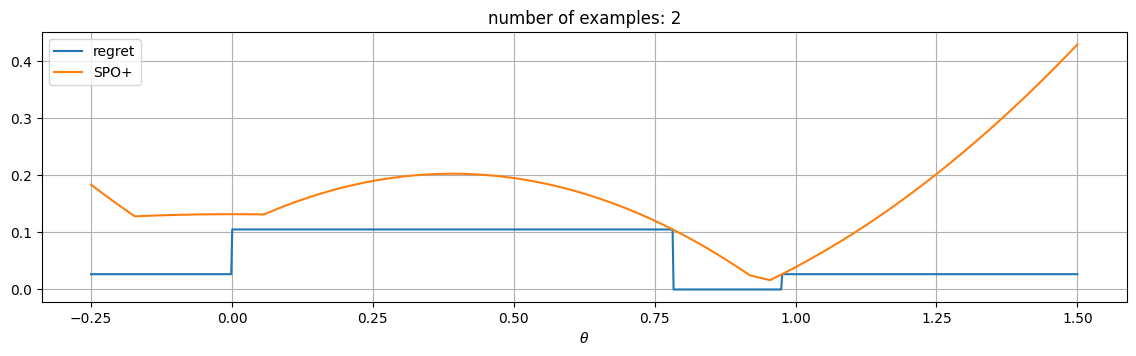

In [15]:
util.draw_loss_landscape(losses=[util.RegretLoss(), util.SPOPlusLoss()], model=1, seed=42, batch_size=2, figsize=figsize)

* The "good" local minima for both examples are roughly in the same place
* The "spurious" local minima fall in different position

## SPO+ Loss

**Over many example, the spurious local minima tend to cancel out**

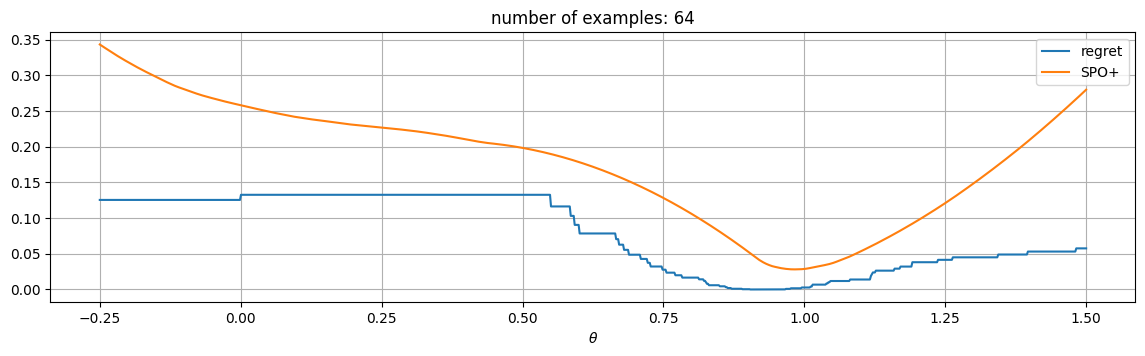

In [28]:
util.draw_loss_landscape(losses=[util.RegretLoss(), util.SPOPlusLoss()], model=1, seed=42, batch_size=64, figsize=figsize)

* This effect is _invaluable_ when training with gradient descent

<div class=big>
    Let's see the approach in action on a single problem
</div>

## A (Sligthly) More Complex Example

**We will consider an optimization problem in this form:**

$$
z^*(y) = \text{argmin} \{y^T z \mid v^T z \geq r, z \in \{0, 1\}^n \}
$$

* We need to decide which of a set of jobs to accept
* Accepting a job ($z_j = 1$) provides immediate value $v_j$
* The cost $y_j$ of the job is not known
* ...But it can be estimated based on available data

In [18]:
nitems, rel_req, seed = 20, 0.5, 42
prb = util.generate_problem(nitems=nitems, rel_req=rel_req, seed=seed)
display(prb)

ProductionProblem(values=[1.14981605 1.38028572 1.29279758 1.23946339 1.06240746 1.06239781
 1.02323344 1.34647046 1.240446   1.28322903 1.0082338  1.38796394
 1.33297706 1.08493564 1.07272999 1.0733618  1.1216969  1.20990257
 1.17277801 1.11649166], requirement=11.830809153591138)

## A (Sligthly) More Complex Example

**Next, we generate some training (and test) data**

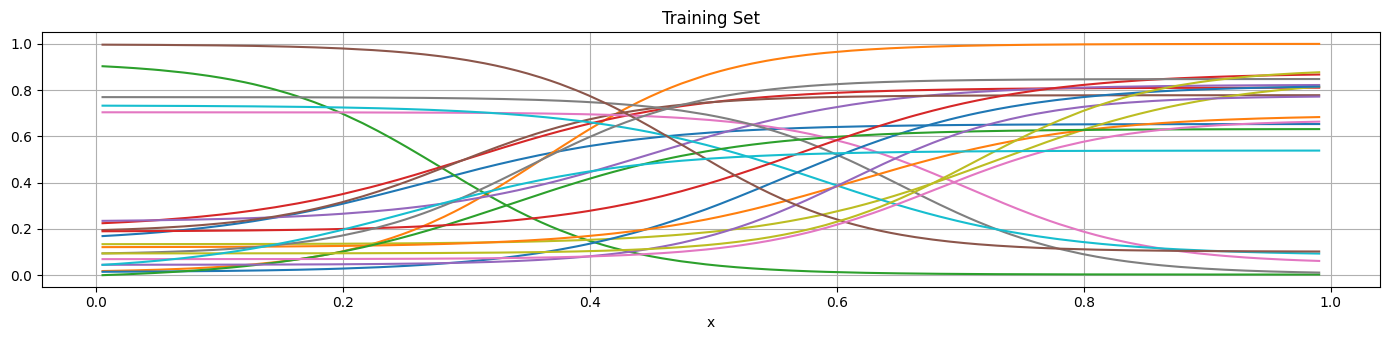

In [19]:
data_tr = util.generate_costs(nsamples=350, nitems=nitems, seed=seed, noise_scale=0, noise_type='normal', noise_scale_type='absolute')
data_ts = util.generate_costs(nsamples=150, nitems=nitems, seed=seed, sampling_seed=seed+1, noise_scale=0, noise_type='normal', noise_scale_type='absolute')
util.plot_df_cols(data_tr, figsize=figsize, title='Training Set')

* We assume that costs can be estimated based on an scalar observable $x$
* The set of least expensive jobs changes considerably with $x$

## Prediction Focused Approach

**As a baseline, we'll consider a basic prediction-focused approach**

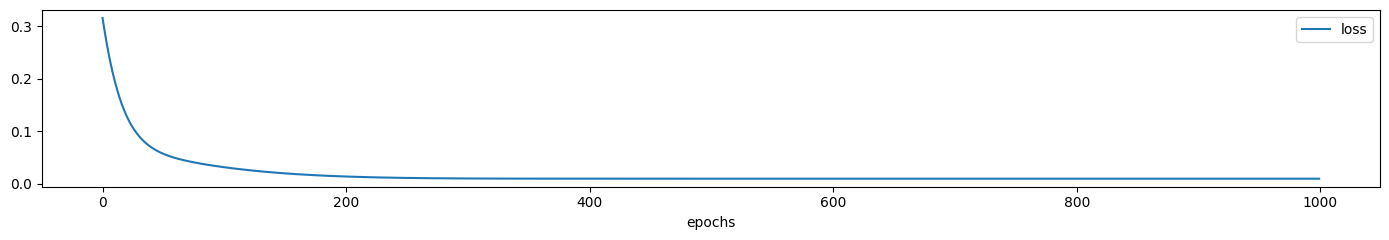

Training time: 7.0220 sec
R2: 0.86, MAE: 0.086, RMSE: 0.10 (training)
R2: 0.86, MAE: 0.087, RMSE: 0.10 (test)


In [20]:
pfl = util.build_ml_model(input_size=1, output_size=nitems, hidden=[], name='pfl_det', output_activation='linear')
history = util.train_ml_model(pfl, data_tr.index.values, data_tr.values, epochs=1000, loss='mse', validation_split=0, save_weights=True, load_weights=use_cached_weights)
util.plot_training_history(history, figsize=figsize_narrow, print_scores=False, print_time=True)
util.print_ml_metrics(pfl, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(pfl, data_ts.index.values, data_ts.values, label='test')

* The ML model is just a linear regressor, but it is decently accurate

## Prediction Focused Approach

**...But our true evaluation should be in terms of regret**

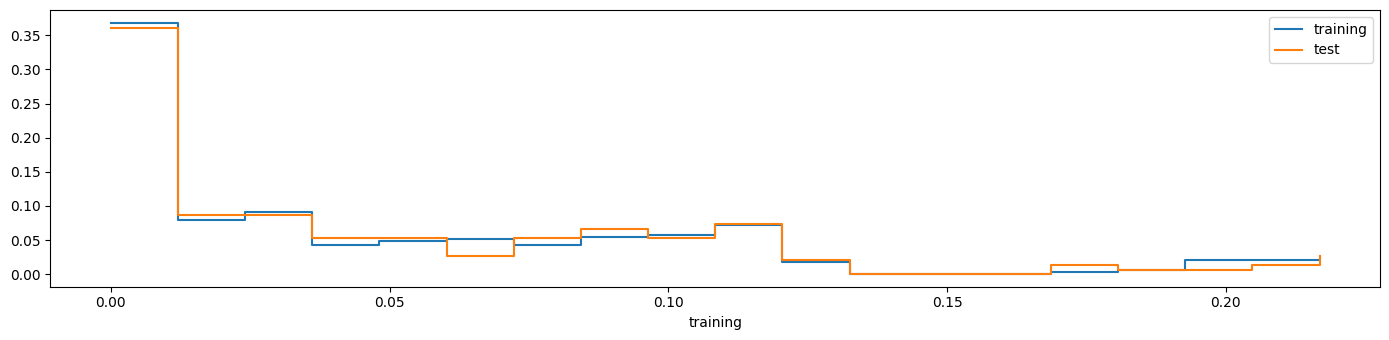

Mean: 0.052 (training), 0.052 (test)


In [21]:
r_tr = util.compute_regret(prb, pfl, data_tr.index.values, data_tr.values)
r_ts = util.compute_regret(prb, pfl, data_ts.index.values, data_ts.values)
util.plot_histogram(r_tr, figsize=figsize, label='training', data2=r_ts, label2='test', print_mean=True)

* In this case, the average _relative_ regret is ~5%

## A Decision Focused Learning Approach

**Next, we train a DFL approach**

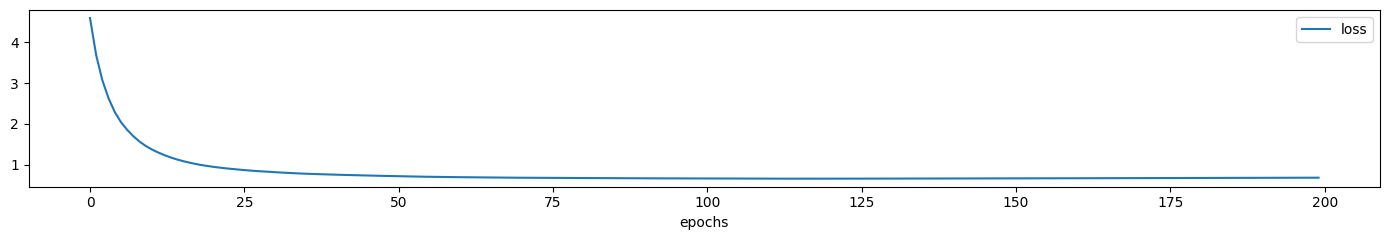

Training time: 94.6590 sec
R2: -0.24, MAE: 0.23, RMSE: 0.28 (training)
R2: -0.23, MAE: 0.23, RMSE: 0.27 (test)


In [22]:
spo = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, hidden=[], name='spo', output_activation='linear', loss_type='spo')
history = util.train_dfl_model(spo, data_tr.index.values, data_tr.values, epochs=200, verbose=0, validation_split=0, save_weights=True, load_weights=use_cached_weights)
util.plot_training_history(history, figsize=figsize_narrow, print_scores=False, print_time=True)
util.print_ml_metrics(spo, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(spo, data_ts.index.values, data_ts.values, label='test')

In terms of accuracy, this is considerably worse

## Comparing Regrets

**But the regret is so much better!**

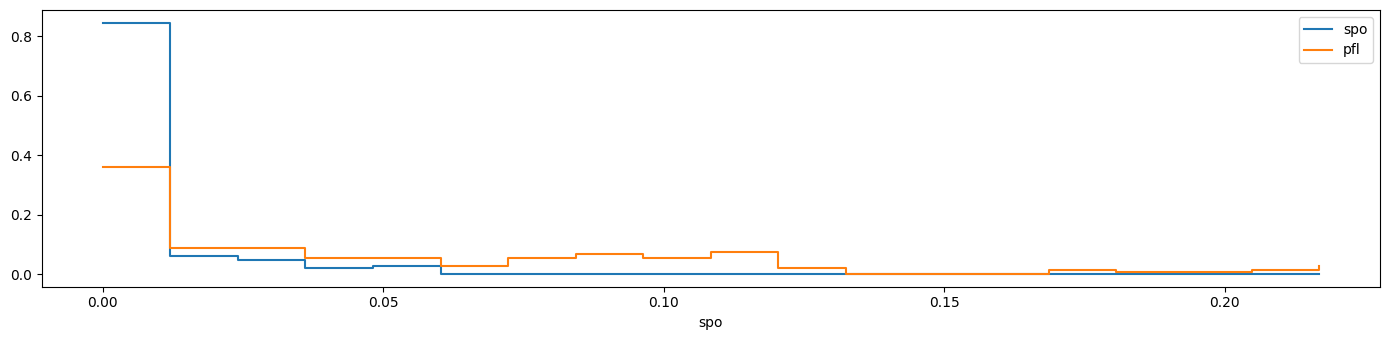

Mean: 0.005 (spo), 0.052 (pfl)


In [23]:
r_ts_spo = util.compute_regret(prb, spo, data_ts.index.values, data_ts.values)
util.plot_histogram(r_ts_spo, figsize=figsize, label='spo', data2=r_ts, label2='pfl', print_mean=True)

This is the kind of result that attracted so much attention since [2]

<small><i>
[2] Donti, Priya, Brandon Amos, and J. Zico Kolter. "Task-based end-to-end model learning in stochastic optimization." Advances in neural information processing systems 30 (2017).
</i></small>